# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [0]:
# !pip uninstall torch

In [0]:
# !pip uninstall torchvision

In [0]:
!pip install torch==1.0.1 -f https://download.pytorch.org/whl/cu100/stable
!pip install torchvision==0.2.1

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Load the data

In [0]:
# !wget https://cdn.talentsprint.com/aiml/FaceRecogHackathon/Datasets/ATandT/data-20190607T005435Z-001.zip

--2019-06-08 18:06:33--  https://cdn.talentsprint.com/aiml/FaceRecogHackathon/Datasets/ATandT/data-20190607T005435Z-001.zip
Resolving cdn.talentsprint.com (cdn.talentsprint.com)... 178.79.149.63
Connecting to cdn.talentsprint.com (cdn.talentsprint.com)|178.79.149.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818386 (3.6M) [application/zip]
Saving to: ‘data-20190607T005435Z-001.zip’

data-20190607T00543 100%[===================>]   3.64M  5.45MB/s    in 0.7s    

2019-06-08 18:06:34 (5.45 MB/s) - ‘data-20190607T005435Z-001.zip’ saved [3818386/3818386]



In [0]:
%ls

data/  data-20190607T005435Z-001.zip  sample_data/


In [0]:
!unzip data-20190607T005435Z-001.zip

## Configuration Class
A simple class to manage configuration

**Siamese with Faces dataset one-shot**

In [0]:

class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

### Display a sample image

(112, 92, 3)


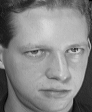

In [0]:
import cv2
from google.colab.patches import cv2_imshow

im1 = cv2.imread('./data/faces/training/s1/10.pgm')
print(im1.shape)
cv2_imshow(im1)

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [0]:
# Create imageFolder dataset 
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
#Create SiameseNetworkDataset (defined earlier in this notebook); chiefly the data retriever (get_item) is overriden to
#..provide pair of images + similar/dissimilar label. 
#NOTE: the TRANSFORMS HERE CONSISTS OF a) resizing to 100*100 b) Converting to tensor.YOU HAVE TO APPLY SAME..
#..TRANSORMS WHEN DEPLOYING THE MODEL ON THE SERVER!! 
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [0]:
# Nonechucks is not needed for this dataset. But in cases where you dataloader gives image not found error i.e.
#..in cases where image is malformed, nonechucks helps in eliminating those images so that your dataloader doesn't fail.
# So good practise to use this code below
!pip install nonechucks
import nonechucks as nc

  Stored in directory: /root/.cache/pip/wheels/d1/81/6d/c4984a169f36e27cc2e7c65d4f6e52d51f5ee66080065144d1
Successfully built nonechucks


In [0]:
siamese_dataset = nc.SafeDataset(siamese_dataset)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

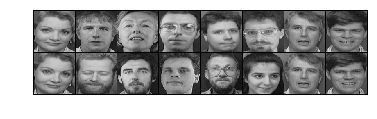

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [0]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
%%capture
for epoch in range(0,Config.train_number_epochs):
   
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter,loss_history)

In [0]:
## Saving the model as a state dictionary
state = {
    'net_dict': net.state_dict()
}


torch.save(state, './siamese_model.t7')

**Testing with load_state_dict**

In [0]:
myModel = SiameseNetwork().cuda()

In [0]:
%ls

data/  data-20190607T005435Z-001.zip  sample_data/  siamese_model.t7


In [0]:
ckpt = torch.load('./siamese_model.t7')

In [0]:
myModel.load_state_dict(ckpt['net_dict'])

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.training_dir) #testing_dir
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

siamese_dataset = nc.SafeDataset(siamese_dataset)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    print(type(x0),x0.shape)
    
    output1,output2 = myModel(Variable(x0).cuda(),Variable(x1).cuda()) #using the loaded 'myModel'; even 'net' can be used
    #..but using 'myModel' helps a quick test on if the save and load model is working fine. You will replicate the same
    #..in the server.

    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



## Train a classifier for face recognition by using Siamese representation of the Siamese model trained above

### Load your 6 class team dataset location under 'finalClassificationDset'

In [0]:
#Here simple ImageFolder is enough; we don't need SiameseDataSet 
finalClassifierDset = dset.ImageFolder(root='./finalClassificationDset',transform = 
                                       transforms.Compose([transforms.Grayscale(num_output_channels = 1)
                                                           ,transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

In [0]:
#Dataloader using the dataset created above.
representation_dataloader = DataLoader(finalClassifierDset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=100)

In [0]:
###Loading the state dict of the siamese model
#<YOUR CODE HERE>


In [0]:
##Get a siamese representation of each of your data.
#<YOUR CODE HERE>
  

In [0]:
## Now train a classifier to use the classify using the representations achieved above. This can be a simple MLP with Pytorch
## Or sklearn model is also fine. However you'll have to ensure you convert torch variable to numpy array before using SkLearn

In [0]:
## Save the model, using state-dict, in case you're using Pytorch.  If you're final classifier is created using SkLearn use joblib
